In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
#from scipy.fft import fft, fftfreq, fftshift, fft2,ifft2,rfft2,irfft2
import scipy.fft as fft 
import time
from numba import jit, njit, types, vectorize, objmode

import GaussianBeamLib.GaussianBeamTypes as GaussianFuncs
import GaussianBeamLib.OpticalOperators as OpticOp
import QuantumGateModes.QuantumGateGenerator as QuModes



In [2]:
%load_ext autoreload
%aimport GaussianBeamLib.GaussianBeamTypes
#%aimport UsefulFunction.PlottingFunctions
%aimport GaussianBeamLib.OpticalOperators
%aimport QuantumGateModes.QuantumGateGenerator 
%autoreload 1

In [3]:
def cart2pol(X_vec, Y_vec):
    TH_vec = np.arctan2(Y_vec, X_vec);
    R_vec = np.sqrt(X_vec**2 + Y_vec**2);
    return TH_vec, R_vec

def pol2cat(TH_vec,R_vec):
  X_vec = R_vec * np.cos(TH_vec);
  Y_vec = R_vec * np.sin(TH_vec);
  return X_vec,Y_vec

In [4]:
Nx=320
Ny=320
MFD=350e-6
wavelength=1550e-9
z_dist=0
pixelSize=9.2e-6
maxMG=9
modeCount=sum(range(maxMG+1))
xmin=(((-(Nx-1))/2.0))*pixelSize
xmax=(((Nx-1)/2.0))*pixelSize
ymin=(((-(Ny-1))/2.0))*pixelSize
ymax=(((Ny-1)/2.0))*pixelSize
xArr=np.linspace(xmin,xmax,Nx)
yArr=np.linspace(ymin,ymax,Ny)

XGrid,YGrid=np.meshgrid(xArr,yArr)
# PhaseArray=np.linspace(0,2*np.pi,256)
PhaseArray=np.linspace(-1*np.pi,np.pi,256)

# Make the HG modes the other modes will be compared to

In [31]:
TH_vec,R_vec=cart2pol(XGrid, YGrid)
TH_vec=TH_vec+np.pi/4.0
XGridTemp,YGridTemp=pol2cat(TH_vec,R_vec)

HGmodes=np.zeros((modeCount,Nx,Ny),dtype=np.complex128)
ReadFromFile=True
if(ReadFromFile):
    # l_array,p_array=GaussianFuncs.ReadIndexFromFile("LGAzimuthal_minus8_plus8.txt")
    l_array,p_array=GaussianFuncs.ReadIndexFromFile("LGAzimuthal_plus8_minus8.txt")

    LGmodes=np.zeros((len(l_array),Nx,Ny),dtype=np.complex128)
else:
    LGmodes=np.zeros((modeCount,Nx,Ny),dtype=np.complex128)

imode=0
for mgIdx in range(maxMG):
    #zero-based index of the mode-group
    mgIDX = mgIdx;
    #For every mode in this group (there will be mgIdx of them)
    for modeIdx in range(mgIdx+1):
        #m+n should equal mgIDX.
        #Go through each m,n combo in this group starting with max m

        m = mgIDX-(modeIdx);
        n = mgIDX-m;
        # if(ReadFromFile):
        #     l=int(l_array[imode])
        #     p=int(p_array[imode])
        # else:
        #     l=m-n;
        #     p=min([n,m]);
        #Calculate this HG(m,n) mode
        HGmodes[imode,:,:]= GaussianFuncs.GenerateHGMode(MFD, wavelength,m,n, XGridTemp, YGridTemp, z_dist, 0)
        # LGmodes[imode,:,:]= GaussianFuncs.GenerateLGMode(MFD, wavelength,p,l,XGrid,YGrid, z_dist, 0)

        # HGmodeMFD(X,Y,mfd,m,n);
        # #Store the resulting field
        # MODES(idx,:,:) = MODE;
        #Increment mode index
        # plt.figure()
        # plt.imshow(GaussianFuncs.ComplexArrayToRgb(HGmodes[imode,:,:]))
        # plt.axis('off')
       

        imode=imode+1;

for imode in range(len(l_array)):
    l=int(l_array[imode])
    p=int(p_array[imode])
    LGmodes[imode,:,:]= GaussianFuncs.GenerateLGMode(MFD, wavelength,p,l,XGrid,YGrid, z_dist, 0)

# TotalMode=np.zeros((Nx,Ny),dtype=np.complex128)
# for imode in range(modeCount):
#     TotalMode=TotalMode+abs(HGmodes[imode,:,:])

# plt.figure()
# plt.imshow(GaussianFuncs.ComplexArrayToRgb(TotalMode[:,:]))
# plt.axis('off')

# Make other modes

## Make LG modes

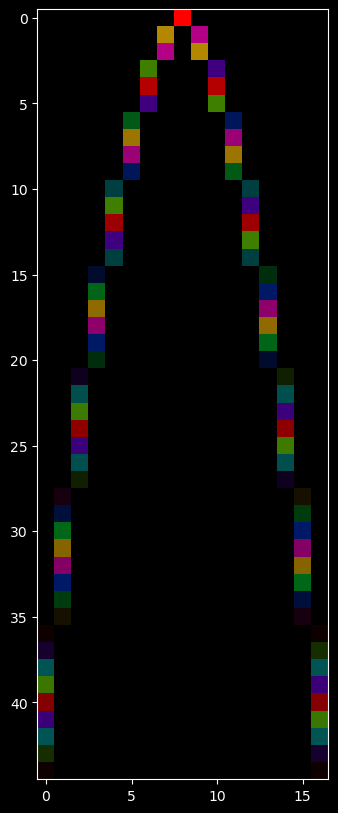

In [51]:
imodeShiftIdx=modeCount-7
basisModeCount=17
# TransformMatrix=np.zeros((basisModeCount,modeCount),np.complex64)
TransformMatrix=np.zeros((modeCount,basisModeCount),np.complex64)

for imodeBasis in range(basisModeCount):
    for imode in range(modeCount):
        # TransformMatrix[imodeBasis,imode]=OpticOp.overlap(LGmodes[imodeBasis+imodeShiftIdx,:,:],HGmodes[imode,:,:])
        # TransformMatrix[imode,imodeBasis]=OpticOp.overlap(LGmodes[imodeBasis+imodeShiftIdx,:,:],HGmodes[imode,:,:])
        # TransformMatrix[imode,imodeBasis]=OpticOp.overlap(HGmodes[imode,:,:],LGmodes[imodeBasis+imodeShiftIdx,:,:])
        TransformMatrix[imode,imodeBasis]=OpticOp.overlap(HGmodes[imode,:,:],LGmodes[imodeBasis,:,:])

        

     
     
     
plt.imshow(GaussianFuncs.ComplexArrayToRgb(TransformMatrix))

In [52]:
# Filename="TransformMatrix_LGAziumthal_Minus8ToPlus8.npy"
Filename="TransformMatrix_LGAziumthal_PLus8ToMinus8.npy"

FileTosave="Data\\"+Filename
np.save(FileTosave,TransformMatrix)

# Make Quantum Gate modes

In [32]:
l_array,p_array=GaussianFuncs.ReadIndexFromFile("LGAzimuthal_minus8_plus8.txt")
l_array,p_array=GaussianFuncs.ReadIndexFromFile("LGAzimuthal_plus8_minus8.txt")

modeIndex=np.asarray([p_array,l_array],dtype=int)
print(modeIndex)
LGmodesAzimth=QuModes.GenerateLGAzthmModes(x=xArr,y=yArr,z_dist=0,MFD=MFD,wavelen=1565e-9,modeIndeices=modeIndex)


[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 8  7  6  5  4  3  2  1  0 -1 -2 -3 -4 -5 -6 -7 -8]]
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 8  7  6  5  4  3  2  1  0 -1 -2 -3 -4 -5 -6 -7 -8]]


In [33]:
DFTmodes,_=QuModes.GenerateDFTGateOutput(LGmodesAzimth)
# Xmodes,mat=QuModes.GenerateXGateOutput(LGmodesAzimth)
# Zmodes,mat=QuModes.GenerateZGateOutput(LGmodesAzimth)



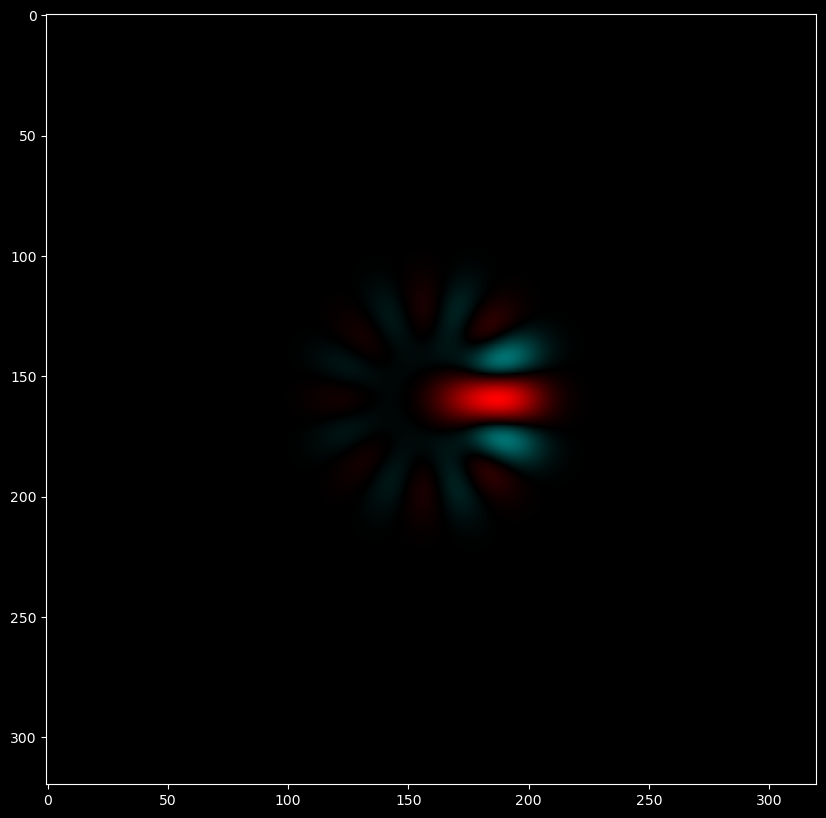

In [37]:
plt.imshow(GaussianFuncs.ComplexArrayToRgb(DFTmodes[8,:,:]))


In [35]:
import copy

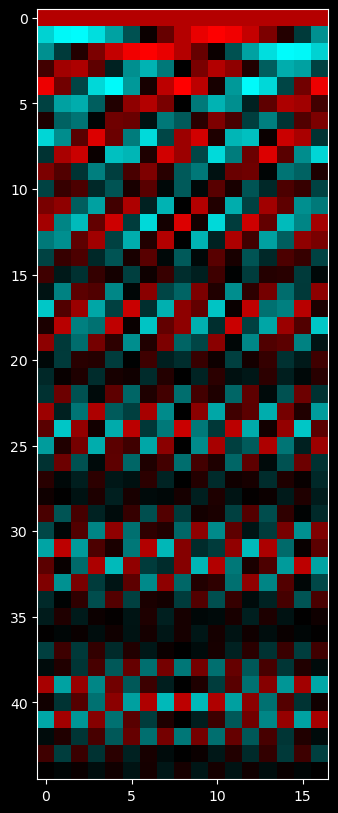

In [36]:
# imodeShiftIdx=modeCount-7
basisModeCount=17
# TransformMatrix=np.zeros((basisModeCount,modeCount),np.complex64)
TransformMatrix=np.zeros((modeCount,basisModeCount),np.complex64)
InputModes=copy.deepcopy(DFTmodes)
for imodeBasis in range(basisModeCount):
    for imode in range(modeCount):
        # TransformMatrix[imodeBasis,imode]=OpticOp.overlap(LGmodes[imodeBasis+imodeShiftIdx,:,:],HGmodes[imode,:,:])
        # TransformMatrix[imode,imodeBasis]=OpticOp.overlap(LGmodes[imodeBasis+imodeShiftIdx,:,:],HGmodes[imode,:,:])
        # TransformMatrix[imode,imodeBasis]=OpticOp.overlap(HGmodes[imode,:,:],LGmodes[imodeBasis+imodeShiftIdx,:,:])
        TransformMatrix[imode,imodeBasis]=OpticOp.overlap(HGmodes[imode,:,:],InputModes[imodeBasis,:,:])

        

     
     
     
plt.imshow(GaussianFuncs.ComplexArrayToRgb(TransformMatrix))
Filename="TransformMatrix_LGAziumthal_PLus8ToMinus8_DFT_Gate.npy"
# Filename="TransformMatrix_LGAziumthal_Minus8ToPlus8_DFT_Gate.npy"

FileTosave="Data\\"+Filename
np.save(FileTosave,TransformMatrix)